### Importação de bibliotecas python

In [1]:
import os
import json
import pickle
import neptune
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Importação de módulos do projeto

In [2]:
os.chdir("..")

In [3]:
from calysto.feature_engineering import Engineering

### Load Settings

In [4]:
feature_params = json.load(open("settings/dataprep_improved.json", "r"))

### Read Data

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [7]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [8]:
X = train[list(train.columns)]
y = train[["SalePrice"]]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

In [11]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
788,789,20,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,107900
903,904,20,RL,50.0,14859,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,240000
1297,1298,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500


In [40]:
variavel_analise =  "Functional"

In [41]:
DescribeCount = test.\
    fillna('missing').\
    groupby([variavel_analise])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Functional,count
0,Maj1,5.0
1,Maj2,4.0
2,Min1,34.0
3,Min2,36.0
4,Mod,20.0
5,Sev,1.0
6,Typ,1357.0
7,missing,2.0


In [42]:
DescribeCount = X_train .\
    fillna('missing').\
    groupby([variavel_analise])['SalePrice'].\
    describe().\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Functional,count,mean,std,min,25%,50%,75%,max
0,Maj1,11.0,134979.5,46931.6,60000.0,128500.0,130000.0,147700.0,213250.0
1,Maj2,5.0,85800.0,27086.9,52000.0,67000.0,85000.0,110000.0,115000.0
2,Min1,25.0,143230.0,37795.1,82000.0,122500.0,138000.0,160000.0,256000.0
3,Min2,28.0,142521.4,44860.8,87000.0,115750.0,139800.0,163375.0,316600.0
4,Mod,11.0,133127.3,60254.9,55000.0,87250.0,124000.0,175000.0,241500.0
5,Sev,1.0,129000.0,NaN,129000.0,129000.0,129000.0,129000.0,129000.0
6,Typ,1087.0,185814.4,81636.5,34900.0,132500.0,169000.0,221250.0,755000.0


In [43]:
X_train[variavel_analise].fillna('missing').unique()

array(['Typ', 'Mod', 'Min2', 'Min1', 'Maj1', 'Maj2', 'Sev'], dtype=object)

In [44]:
exp_data = X_train[["Id", variavel_analise, "SalePrice"]].fillna("missing")

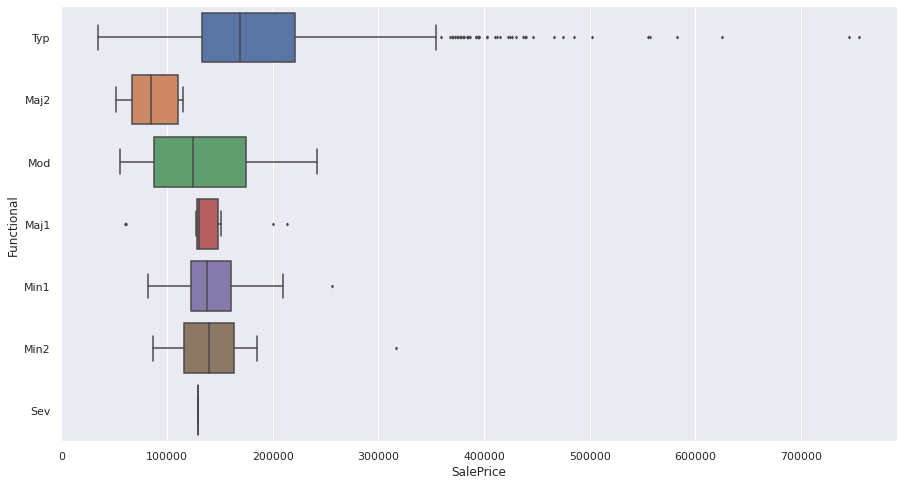

In [45]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data.sort_values("SalePrice"),
                 orient="h", fliersize=2)

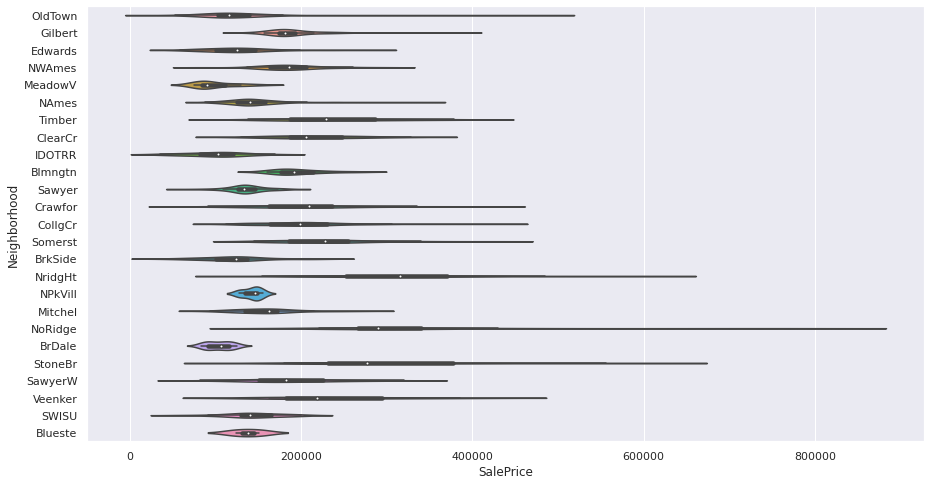

In [29]:
plt.figure(figsize=(15,8))
ax = sns.violinplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data,
                 orient="h", fliersize=2)

In [20]:
import scipy

In [ ]:
plt.figure(figsize=(15,8))
i = 0
for classe in exp_data[variavel_analise].unique():
    d = pd.DataFrame(exp_data.loc[exp_data[variavel_analise] == classe, "SalePrice"])
    d.rename(columns={'SalePrice': classe}, inplace=True)
    p1=sns.kdeplot(d[classe],
                   shade=True, 
                   color=sns.color_palette("hls", 12)[i])
    i=i+2

In [ ]:
X_train.loc[X_train["Id"] == 124]